<a href="https://colab.research.google.com/github/flakesynto/MSc-Project/blob/main/seg_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy pandas matplotlib notebook scikit-image scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.1 MB/s eta 0:00:00


In [6]:

# system libraries
import os
import warnings

# ignoring all the warnings
warnings.simplefilter('ignore')

# import data handling libraries
import numpy as np
import pandas as pd

# importing data visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline

# import image processing library
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

In [15]:

r = os.listdir(r"/content/images/")
# This is the path to the image folder

print(r[0:10])

['4.dcm', '1.dcm', '2.dcm', '3.dcm', '5.dcm']


In [20]:
import pydicom
limit = 100
# Creating the list of blank spaces that can potentially hold data:
ra_images = [None]*limit

# Creating loop variables:
i, j = 0, 0

# This part of the code loops over all the images
# in the list "r" and reads it into the jth element
# of the array we made in line 2.
for i in r:
    if(j<limit):
        ra_images[j] = pydicom.dcmread(r"/content/images/" + i)
        j+= 1
    else:
        break

# Similarly, we will fill up the data into the other 2 arrays

In [27]:

# Finding out the number of columns per image in our dataset.
# We will use the shape function on any one image in our array
# and use the dimensions we get as the number of columns in row.
number_of_columns = ra[1].shape[0] * ra[1].shape[1]
print(number_of_columns)

# This means we will be using this many columns
# per row in our dataset.
# Our dataset has 300 images, so:
# Our dataset will be an array of dimensions
# 784 x 300 => 300 images of 784 pixels each.

NameError: name 'ra' is not defined

In [19]:
pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.7 MB/s eta 0:00:00


In [28]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output

In [29]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIJKDG4/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIJKDG4/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Data Processing

In [31]:
def normalize(input_image, input_mask):

    # Normalize the pixel range values between [0:1]
    img = tf.cast(input_image, dtype=tf.float32) / 255.0
    input_mask -= 1
    return img, input_mask

@tf.function
def load_train_ds(dataset):
    img = tf.image.resize(dataset['image'],
                          size=(width, height))
    mask = tf.image.resize(dataset['segmentation_mask'],
                           size=(width, height))

    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    img, mask = normalize(img, mask)
    return img, mask

@tf.function
def load_test_ds(dataset):
    img = tf.image.resize(dataset['image'],
                          size=(width, height))
    mask = tf.image.resize(dataset['segmentation_mask'],
                           size=(width, height))

    img, mask = normalize(img, mask)
    return img, mask

In [33]:
TRAIN_LENGTH = info.splits['train'].num_examples

# Batch size is the number of examples used in one training example.
# It is mostly a power of 2
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# For VGG16 this is the input size
width, height = 224, 224

In [34]:

train = dataset['train'].map(
    load_train_ds, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_test_ds)

train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)

Visualizing Data

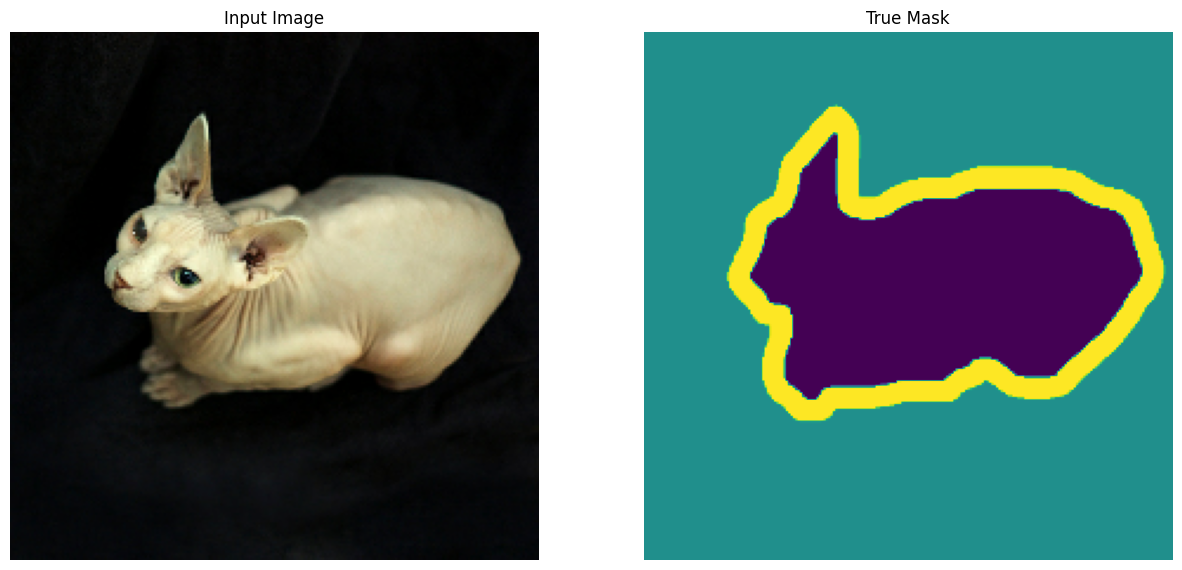

In [35]:
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask',
             'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()


for img, mask in train.take(1):
    sample_image, sample_mask = img, mask
    display_list = sample_image, sample_mask

display_images(display_list)

U-Net
U-Net is a CNN architecture used for most of the segmentation tasks. It consists of a contraction and expansion path which gives it the name UNet. The contraction path consists of a convolution layer, followed by ReLu followed by max-pooling layers. Along the contraction path, the features get extracted and the spatial information is reduced.
Along the expansion path, a series of up convolutions along with concatenation of nigh resolution features are done from the contraction path.

For this project, we will use the encoder of the VGG16 model as it is already trained on the ImageNet dataset and has learned some features. If the original UNet encoder is used it will learn everything from scratch and will take more time.

In [37]:

base_model = keras.applications.vgg16.VGG16(
    include_top=False, input_shape=(width, height, 3))

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input,
                               base_model_outputs)

58889256/58889256 [==============================] - 0s 0us/step


In [38]:
#Now define the decoder
def fcn8_decoder(convs, n_classes):
    f1, f2, f3, f4, p5 = convs

    n = 4096
    c6 = tf.keras.layers.Conv2D(
        n, (7, 7), activation='relu', padding='same',
      name="conv6")(p5)
    c7 = tf.keras.layers.Conv2D(
        n, (1, 1), activation='relu', padding='same',
      name="conv7")(c6)

    f5 = c7

    # upsample the output of the encoder
    # then crop extra pixels that were introduced
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
        4, 4),  strides=(2, 2), use_bias=False)(f5)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # load the pool 4 prediction and do a 1x1
    # convolution to reshape it to the same shape of `o` above
    o2 = f4
    o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
                                 activation='relu',
                                 padding='same'))(o2)

    # add the results of the upsampling and pool 4 prediction
    o = tf.keras.layers.Add()([o, o2])

    # upsample the resulting tensor of the operation you just did
    o = (tf.keras.layers.Conv2DTranspose(
        n_classes, kernel_size=(4, 4),  strides=(2, 2),
      use_bias=False))(o)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    # load the pool 3 prediction and do a 1x1
    # convolution to reshape it to the same shape of `o` above
    o2 = f3
    o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
                                 activation='relu',
                                 padding='same'))(o2)

    # add the results of the upsampling and pool 3 prediction
    o = tf.keras.layers.Add()([o, o2])

    # upsample up to the size of the original image
    o = tf.keras.layers.Conv2DTranspose(
        n_classes, kernel_size=(8, 8),  strides=(8, 8),
      use_bias=False)(o)

    # append a softmax to get the class probabilities
    o = tf.keras.layers.Activation('softmax')(o)
    return o

In [39]:
def segmentation_model():

    inputs = keras.layers.Input(shape=(width, height, 3))
    convs = VGG_16(inputs)
    outputs = fcn8_decoder(convs, 3)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

1/1 [==============================] - 1s 1s/step


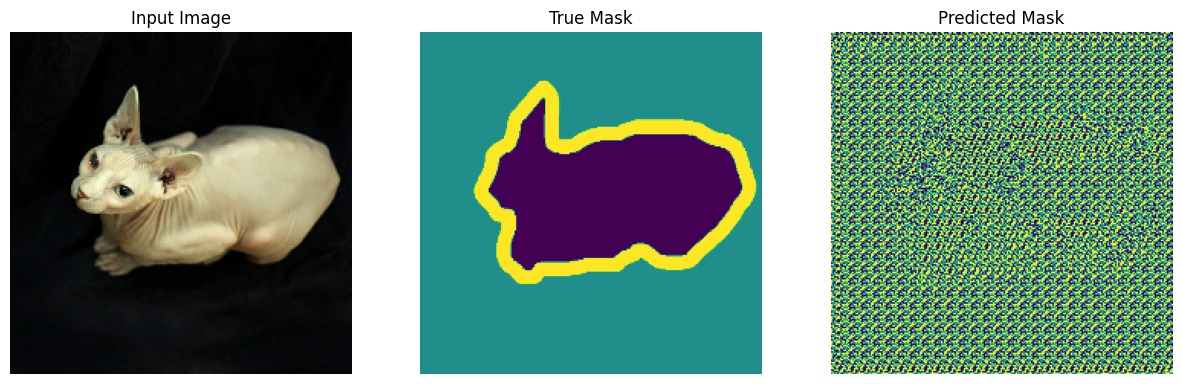

In [40]:
#Creating prediction mask utility
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_images([image[0], mask[0], create_mask(pred_mask)])
    else:
        display_images([sample_image, sample_mask,
                        create_mask(model.predict(sample_image[tf.newaxis, ...]))])


show_predictions()

https://www.geeksforgeeks.org/image-segmentation-using-tensorflow/?ref=lbp
